# Laboratorio 5 - Data Science Universidad del Valle de Guatemala
María Marta Ramírez Gil 21342
Gustavo Andrés Gonzalez 21438 

------------------------------------------------------------------------------

importaciones

In [19]:
import pandas as pd
import re
import string
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import spacy
from itertools import islice

## Cargar los datos

In [2]:
# Cargar el dataset
data_path = 'data/GrammarandProductReviews.csv'
df = pd.read_csv(data_path)

# Ver las primeras filas para entender la estructura
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  object 
 1   brand                 71044 non-null  object 
 2   categories            71044 non-null  object 
 3   dateAdded             71044 non-null  object 
 4   dateUpdated           71044 non-null  object 
 5   ean                   39065 non-null  object 
 6   keys                  71044 non-null  object 
 7   manufacturer          70903 non-null  object 
 8   manufacturerNumber    70841 non-null  object 
 9   name                  71044 non-null  object 
 10  reviews.date          70977 non-null  object 
 11  reviews.dateAdded     71044 non-null  object 
 12  reviews.dateSeen      71044 non-null  object 
 13  reviews.didPurchase   32158 non-null  object 
 14  reviews.doRecommend   60429 non-null  object 
 15  reviews.id         

In [4]:
# observar las columnas que existen
print("columnas:")
df.columns

columnas:


Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc'],
      dtype='object')

## Limpieza y preprocesamiento de dato

preprocesamiento del texto, se relizará lo siguiente:
- Convertir el texto a minúsculas.
- Eliminar caracteres especiales, URLs y números.
- Eliminar los signos de puntuación.
- Eliminar las stopwords.

In [14]:
# Cargar el modelo en inglés de spaCy
nlp = spacy.load('en_core_web_sm')

# Obtener las stopwords en inglés desde spaCy
stop_words = nlp.Defaults.stop_words

# Función para limpiar el texto utilizando spaCy
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Eliminar URLs
    text = re.sub(r'\@|\#', '', text)  # Eliminar menciones y hashtags
    text = re.sub(r'[^\w\s\.,!?-]', '', text)  # Eliminar signos de puntuación, manteniendo .,!?-

    # Procesar el texto con spaCy para la tokenización y eliminación de stopwords
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in stop_words and not token.is_punct]  # Eliminar stopwords y signos de puntuación
    return ' '.join(tokens)

# Aplicar la función a la columna 'reviews.text'
df['cleaned_review'] = df['reviews.text'].apply(lambda x: clean_text(str(x)))

# Ver las primeras filas para confirmar
print(df[['reviews.text', 'cleaned_review']].head())

                                        reviews.text  \
0  i love this album. it's very good. more to the...   
1  Good flavor. This review was collected as part...   
2                                       Good flavor.   
3  I read through the reviews on here before look...   
4  My husband bought this gel for us. The gel cau...   

                                      cleaned_review  
0  love album good hip hop current pop sound hype...  
1             good flavor review collected promotion  
2                                        good flavor  
3  read reviews looking buying couples lubricants...  
4  husband bought gel gel caused irritation felt ...  


## Frencuencia de las palabras

usando las puntuaciones de las reseñas como un indicador de positividad o negatividad.

In [15]:
from collections import Counter

# Separar reseñas en positivas y negativas usando la columna de rating
positive_reviews = df[df['reviews.rating'] >= 4]['cleaned_review']
negative_reviews = df[df['reviews.rating'] <= 2]['cleaned_review']

# Función para contar la frecuencia de las palabras
def get_word_frequencies(reviews):
    words = ' '.join(reviews).split()
    return Counter(words)

# Obtener las frecuencias de palabras en reseñas positivas y negativas
positive_freq = get_word_frequencies(positive_reviews)
negative_freq = get_word_frequencies(negative_reviews)

# Mostrar las 10 palabras más comunes en cada categoría
print("Palabras más comunes en reseñas positivas:", positive_freq.most_common(10))
print("Palabras más comunes en reseñas negativas:", negative_freq.most_common(10))


Palabras más comunes en reseñas positivas: [('great', 19437), ('movie', 17829), ('review', 17138), ('promotion', 16247), ('collected', 16243), ('product', 16072), ('love', 16006), ('use', 13817), ('nt', 12158), ('good', 10216)]
Palabras más comunes en reseñas negativas: [('nt', 3079), ('product', 2874), ('new', 1525), ('like', 1499), ('use', 1414), ('hair', 1289), ('formula', 1276), ('mop', 1146), ('old', 1043), ('tide', 944)]


## Analisis Exploratorio con nubes de palabras y visualizacion de histograma

Creacion de la nube de palabras:

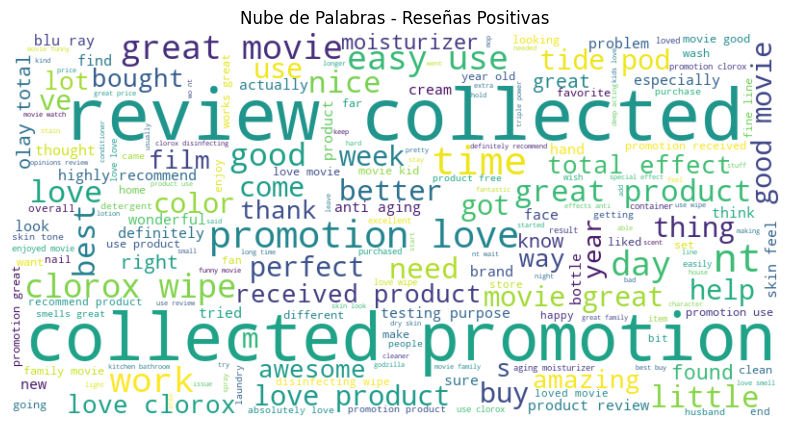

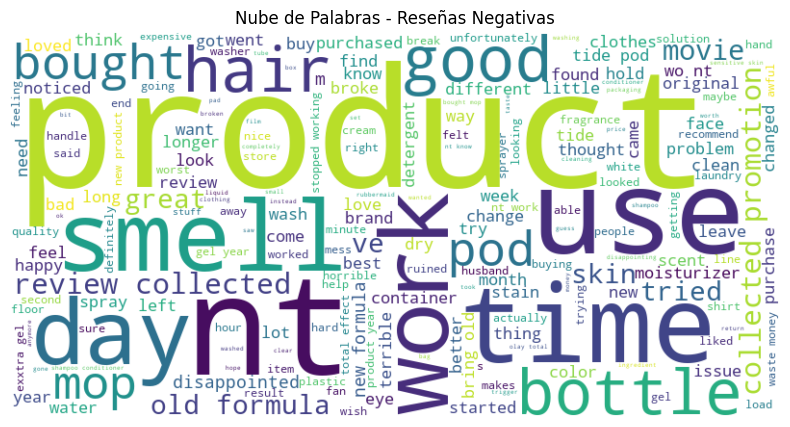

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Nube de palabras para reseñas positivas
positive_text = ' '.join(positive_reviews)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Nube de Palabras - Reseñas Positivas')
plt.show()

# Nube de palabras para reseñas negativas
negative_text = ' '.join(negative_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Nube de Palabras - Reseñas Negativas')
plt.show()


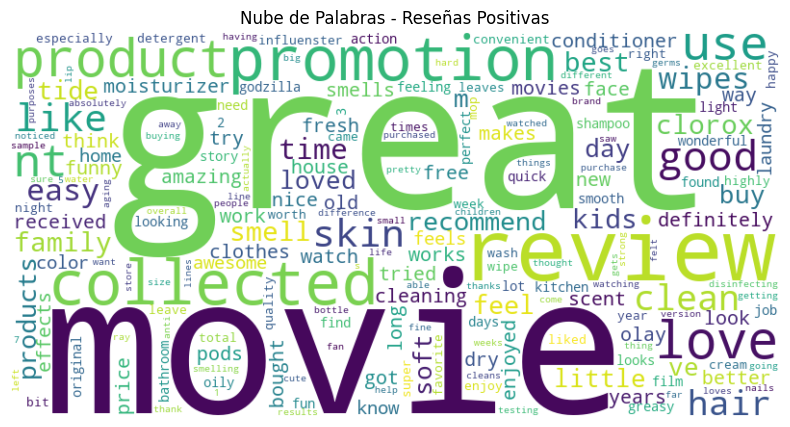

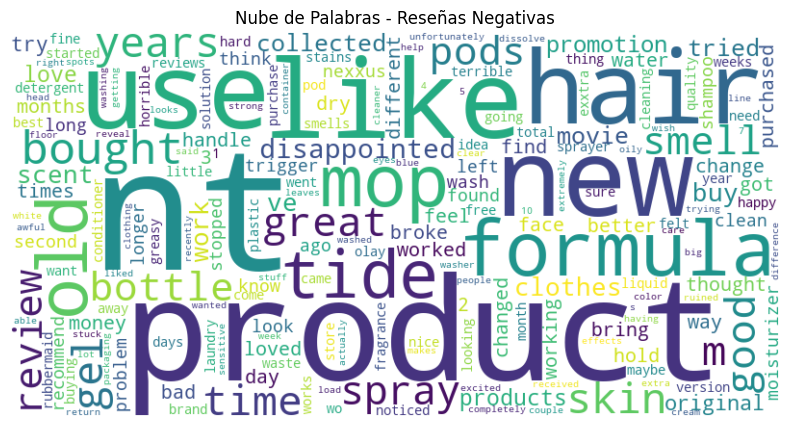

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Función para generar la nube de palabras
def generate_wordcloud(frequencies, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generar nube de palabras para reseñas positivas
generate_wordcloud(positive_freq, "Nube de Palabras - Reseñas Positivas")

# Generar nube de palabras para reseñas negativas
generate_wordcloud(negative_freq, "Nube de Palabras - Reseñas Negativas")


Creacion del histograma

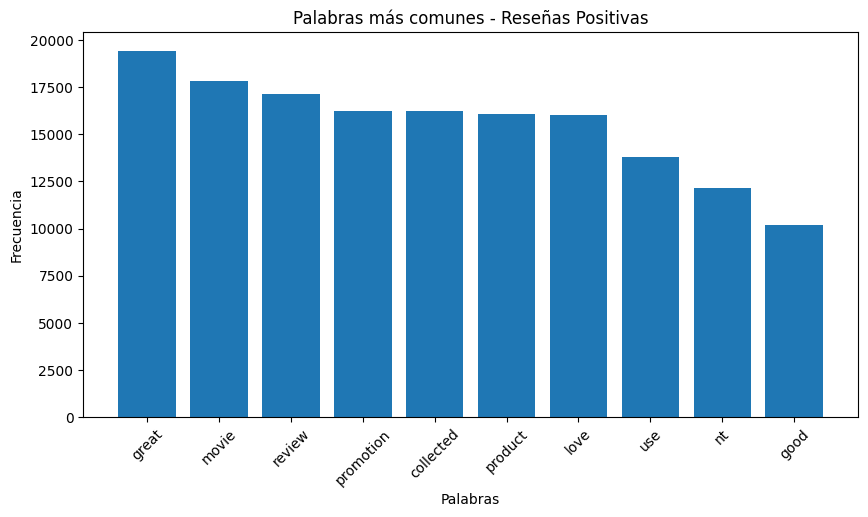

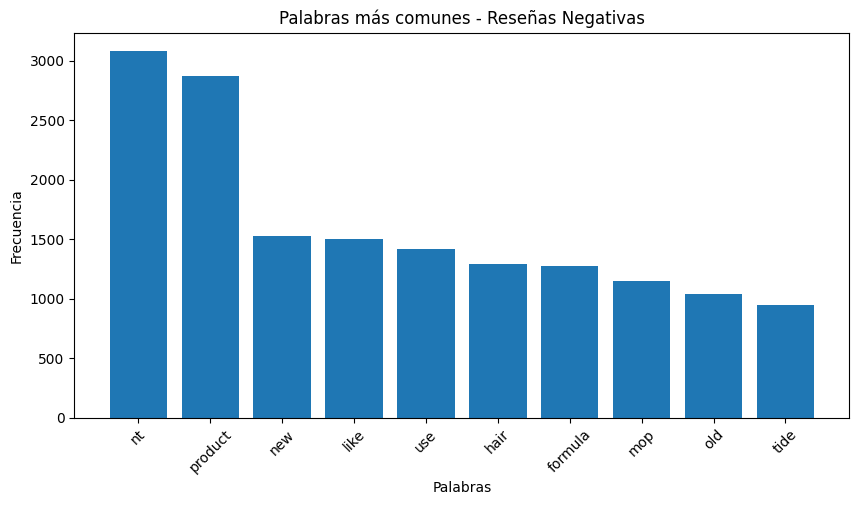

In [17]:
# Crear histograma de las 10 palabras más comunes
def plot_most_common_words(frequencies, title, n=10):
    common_words = frequencies.most_common(n)
    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]

    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

# Histograma de las palabras más comunes en reseñas positivas
plot_most_common_words(positive_freq, "Palabras más comunes - Reseñas Positivas")

# Histograma de las palabras más comunes en reseñas negativas
plot_most_common_words(negative_freq, "Palabras más comunes - Reseñas Negativas")


## Explorar bigramas y trigramas

In [20]:
# Cargar el modelo en inglés de spaCy
nlp = spacy.load('en_core_web_sm')

# Función para generar los n-gramas (en este caso se usara bigramas y trigramas nada mass)
def get_ngrams(text, n=2):
    doc = nlp(text)  # Procesar el texto con spaCy
    tokens = [token.text for token in doc if not token.is_punct]  # Tokenizar eliminando signos de puntuación
    n_grams = zip(*[tokens[i:] for i in range(n)])  # Crear los n-gramas
    return [' '.join(grams) for grams in n_grams]

# Aplicar la función para obtener bigramas en reseñas positivas
positive_bigrams = positive_reviews.apply(lambda x: get_ngrams(str(x), n=2))

# Aplicar la función para obtener trigramas en reseñas negativas
negative_trigrams = negative_reviews.apply(lambda x: get_ngrams(str(x), n=3))

# Ver algunos ejemplos de bigramas y trigramas
print(positive_bigrams.head())
print(negative_trigrams.head())


0     [love album, album good, good hip, hip hop, ho...
1     [good flavor, flavor review, review collected,...
2                                         [good flavor]
20    [noticed product, product clearance, clearance...
21    [product couple, couple times, times recived, ...
Name: cleaned_review, dtype: object
3    [read reviews looking, reviews looking buying,...
4    [husband bought gel, bought gel gel, gel gel c...
5    [boyfriend bought spice, bought spice things, ...
6    [bought earlier today, earlier today excited, ...
7    [bought product husband, product husband try, ...
Name: cleaned_review, dtype: object


### Palabras más comunes en reseñas positivas:
`great`, `movie`, `review`, `promotion`, `collected`, `product`, `love`, `use`, `nt`, `good`

### Palabras más comunes en reseñas negativas:
`nt`, `product`, `new`, `like`, `use`, `hair`, `formula`, `mop`, `old`, `tide`

### Observaciones:
La palabra más común en las reseñas positivas es great, lo que sugiere una tendencia positiva en las opiniones, mientras que en las reseñas negativas, nt y product dominan, lo que refleja que muchos usuarios mencionan el producto directamente cuando están insatisfechos.

## Palabras presentes en ambos archivos

In [22]:
common_words = set(positive_reviews).intersection(set(negative_reviews))
print("Palabras comunes en ambos archivos:", common_words)

Palabras comunes en ambos archivos: {'', 'like movie', 'refillable bottle collapsed sucker went bought replacement bottle guess extra attachments hate buy new mop wood floors 2 dogs like money throw rubbermaid dissapointed product makes question line', 'like', 'purchaed 12443842 3.28 25483701 6.37 formulas exactly prices drastically different    bottle reads ative ingredients n alkyl 60 c14 30 c16 5 c12 5 c18 0.1375 dimethylbenzyl ammonium chloride n alkyl 68 c12 32 c14 0.1375 dimethyl ethlbenzyl ammonium choride 99.7250 ingredients 100.0000 total', 'movie alright acting ok b-', 'good', 'nan'}


### Determinacion de palabras negativas y positivas

In [23]:
nlp = spacy.load("en_core_web_sm")

# Lista de palabras positivas y negativas (modificar AQUI en caso sea neccesario)
positive_words = set(["great", "love", "good", "excellent", "amazing", "fantastic", "wonderful", "best", "positive", "like"])
negative_words = set(["bad", "poor", "terrible", "awful", "worst", "hate", "negative", "dislike", "problem", "issue"])

# Función para extraer palabras positivas y negativas de un texto
def get_sentiment_words(text):
    doc = nlp(text)
    positive_in_review = [token.text for token in doc if token.text in positive_words]
    negative_in_review = [token.text for token in doc if token.text in negative_words]
    return positive_in_review, negative_in_review

# Aplicar la función a las reseñas positivas y negativas
positive_reviews_words = positive_reviews.apply(lambda x: get_sentiment_words(x)[0])  # Palabras positivas
negative_reviews_words = negative_reviews.apply(lambda x: get_sentiment_words(x)[1])  # Palabras negativas

# Mostrar algunas palabras positivas y negativas encontradas
print(f"Palabras positivas encontradas: {positive_reviews_words.head()}")
print(f"Palabras negativas encontradas: {negative_reviews_words.head()}")


Palabras positivas encontradas: 0           [love, good]
1                 [good]
2                 [good]
20    [love, like, like]
21          [good, good]
Name: cleaned_review, dtype: object
Palabras negativas encontradas: 3    []
4    []
5    []
6    []
7    []
Name: cleaned_review, dtype: object


## Determinar el Sentimiento de las Reseñas

In [24]:
def analyze_sentiment(text):
    doc = nlp(text.lower())
    tokens = [token.text for token in doc]
    pos_count = len([word for word in tokens if word in positive_words])
    neg_count = len([word for word in tokens if word in negative_words])
    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['cleaned_review'].apply(analyze_sentiment)

## Analisis de Productos 

Top 10 mejores productos de calidad

In [33]:
best_products = df[df['sentiment'] == 'positive']['id'].value_counts().head(10)
print("Productos de mejor calidad:")
print(best_products)


Productos de mejor calidad:
AVpf3VOfilAPnD_xjpun    6036
AVpgOPJHLJeJML43KwSj    3256
AVpjDSAZLJeJML43rgNP    2366
AVpfPaoqLJeJML435Xk9    2057
AVph3agoilAPnD_x-Mv3    2035
AVphhorJilAPnD_x6cs7    1961
AVpgaPd61cnluZ0-1FvC    1717
AVpfW8y_LJeJML437ySW    1632
AVphoamL1cnluZ0-EojQ    1570
AVpfJP1C1cnluZ0-e3Xy    1476
Name: id, dtype: int64


Top 10 productos de menor calidad

In [30]:
worst_products = df[df['sentiment'] == 'negative']['id'].value_counts().head(10)
print("Productos de peor calidad:")
print(worst_products)

Productos de peor calidad:
AVph3agoilAPnD_x-Mv3    159
AVpfm8yiLJeJML43AYyu    141
AVphm23filAPnD_x7T1w    129
AVpjDSAZLJeJML43rgNP    111
AVpfPaoqLJeJML435Xk9     73
AVphhorJilAPnD_x6cs7     61
AVpfW8y_LJeJML437ySW     39
AVpf3VOfilAPnD_xjpun     29
AVphoamL1cnluZ0-EojQ     28
AVpgTV4k1cnluZ0-zkei     26
Name: id, dtype: int64


Usuario con mas reseñas

In [31]:
top_reviewers = df['reviews.username'].value_counts().head(10)
print("Usuarios con más reseñas:")
print(top_reviewers)

Usuarios con más reseñas:
An anonymous customer    421
Anonymous                113
Mike                     105
Chris                     88
ByAmazon Customer         58
Dave                      57
John                      49
Rick                      41
James                     32
Robert                    31
Name: reviews.username, dtype: int64


Usuarios con mas reseñas positvas/negativas

In [35]:
top_positive_reviewers = df[df['sentiment'] == 'positive']['reviews.username'].value_counts().head(10)
top_negative_reviewers = df[df['sentiment'] == 'negative']['reviews.username'].value_counts().head(10)
print("Usuarios con más reseñas positivas:")
print(top_positive_reviewers)
print("Usuarios con más reseñas negativas:")
print(top_negative_reviewers)

Usuarios con más reseñas positivas:
An anonymous customer    282
Mike                      65
Anonymous                 63
Chris                     55
Dave                      32
ByAmazon Customer         31
John                      30
James                     22
Rick                      21
Sandy                     20
Name: reviews.username, dtype: int64
Usuarios con más reseñas negativas:
An anonymous customer    16
Kman111                   2
Bob Kaz                   2
Disappointed20            2
Curlieque                 2
Swanky1                   2
Joee                      2
Ali1353                   2
Christina429usc           2
Joyce                     2
Name: reviews.username, dtype: int64


Productores con productos de mejor calidad

In [36]:
best_producers = df[df['sentiment'] == 'positive']['manufacturer'].value_counts().head(10)
print("Productores con productos de mejor calidad:", best_producers)

Productores con productos de mejor calidad: Clorox                           6037
Universal                        3660
Twentieth Century Fox            2730
Test                             2057
Procter & Gamble                 2039
PROCTER & GAMBLE COMPANY, THE    1961
Buena Vista                      1717
L'oreal Paris                    1695
L'Oreal Paris                    1570
AmazonUs/CLOO7                   1476
Name: manufacturer, dtype: int64


Productores con productos de peor calidad

In [37]:
worst_producers = df[df['sentiment'] == 'negative']['manufacturer'].value_counts().head(10)
print("Productores con productos de peor calidad:", worst_producers)

Productores con productos de peor calidad: Procter & Gamble                 159
Nexxus Beauty Products           141
Rubbermaid                       129
Twentieth Century Fox            124
Test                              73
PROCTER & GAMBLE COMPANY, THE     61
L'oreal Paris                     43
Clorox                            29
L'Oreal Paris                     28
Sunbeam Products Inc.             26
Name: manufacturer, dtype: int64


## Discusión de Resultados

Los resultados del análisis de datos de reseñas de productos nos proporcionan una visión clara de la calidad de los productos y las opiniones de los usuarios. El dataset contiene un total de 71,044 entradas, con columnas relevantes que incluyen el ID del producto, la marca, la categoría, las fechas de las reseñas y datos asociados a las opiniones como el texto, la calificación y si el usuario recomendaría o no el producto.

Uno de los puntos clave es el análisis de las palabras más comunes en reseñas positivas y negativas. En las reseñas positivas, palabras como `great`, `product`, `love`, y `good` son predominantes, lo que indica que muchos usuarios valoran la calidad y efectividad del producto. En contraste, las reseñas negativas muestran términos como `nt`, `product`, `new`, y `like`, lo que sugiere quejas sobre productos que no cumplen expectativas o cambios en la fórmula o funcionalidad de productos que los usuarios no recibieron bien.

El análisis de los productos de mejor y peor calidad, basado en las reseñas y puntuaciones, muestra que algunos fabricantes, como `Clorox` y `Procter & Gamble`, aparecen en ambos extremos de la lista, lo que sugiere que, aunque pueden tener productos altamente valorados, también tienen otros que generan insatisfacción en los usuarios.

El análisis de los usuarios revela que un número reducido de usuarios, como `An anonymous customer`(nombre de usuario) y `Mike`, realizan muchas reseñas, tanto positivas como negativas, lo que podría indicar usuarios con tendencias a evaluar una amplia gama de productos.

## Imagine que usted es analista de negocios y que está realizando este análisis para el productor que tiene más productos con malas reseñas ¿Qué le propondría a esta empresa para mejorar sus productos?

La empresa `Procter & Gamble tiene` una cantidad considerable de productos con malas reseñas. Según el análisis de las palabras más comunes en las reseñas negativas, destacan términos como `nt`, `product`, `like`, y `formula`. Esto sugiere que muchos usuarios están insatisfechos con productos que no cumplen sus expectativas o con cambios en la fórmula de productos conocidos. Para mejorar sus productos, propondríamos lo siguiente:
- Revisar la fórmula de los productos: Una queja común parece estar relacionada con cambios en la fórmula, lo que podría haber alterado la efectividad o la percepción del producto. Esta empresa podría beneficiarse de estudios de mercado para comprender mejor qué aspectos de la fórmula original eran más apreciados y considerar la posibilidad de volver a lanzarlos o mantenerlos en versiones clásicas.

- Mejorar la comunicación con los usuarios: Muchos usuarios podrían no estar informados de los cambios en los productos, lo que genera frustración. Se podría implementar una campaña de marketing que explique claramente los cambios y sus beneficios, minimizando la resistencia al cambio.

- Atender problemas recurrentes en productos específicos: Palabras como `like` y `use` sugieren que algunos productos no funcionan como se esperaba. La empresa podría analizar a fondo los productos más criticados e invertir en mejoras de diseño o funcionalidad.

- Relizar constante retroalimentación y hacer pruebas beta: Procter & Gamble podría implementar pruebas con grupos de usuarios antes de lanzar nuevas versiones de productos para obtener retroalimentación temprana y asegurarse de que las mejoras sean bien recibidas por los consumidores finales.

Con estas recomendaciones, Procter & Gamble podría no solo mejorar sus productos sino también restaurar la confianza perdida por lanzar una nueva formula.